In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
tf.config.list_physical_devices('GPU')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall

In [2]:
from tensorflow.keras.callbacks import TensorBoard

In [3]:
df = pd.read_parquet('clean_data.pqt')

In [4]:
X= df['comment_text']
y= df.drop(['id','comment_text'], axis=1)
print(y)

X_train, X_valid, ytrain, yvalid = train_test_split(X,y,test_size=.3, random_state=77)
print(X_train.shape[0])
print(X_valid.shape[0]) 

        toxic  severe_toxic  obscene  threat  insult  identity_hate
0           0             0        0       0       0              0
1           0             0        0       0       0              0
2           0             0        0       0       0              0
3           0             0        0       0       0              0
4           0             0        0       0       0              0
...       ...           ...      ...     ...     ...            ...
159566      0             0        0       0       0              0
159567      0             0        0       0       0              0
159568      0             0        0       0       0              0
159569      0             0        0       0       0              0
159570      0             0        0       0       0              0

[159571 rows x 6 columns]
111699
47872


In [5]:
MAX_VOCAB_SIZE = 200000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_valid = tokenizer.texts_to_sequences(X_valid)

In [6]:
word2idx = tokenizer.word_index
V = len(word2idx)
print(V)

150507


In [7]:
data_train = pad_sequences(sequences_train)
print(data_train.shape)
T= data_train.shape[1]
data_valid = pad_sequences(sequences_valid, maxlen=T)
print(data_valid.shape)

(111699, 1250)
(47872, 1250)


In [10]:
X_train.to_pickle('data_train.pkl')
X_valid.to_pickle('data_valid.pkl')
ytrain.to_pickle('ytrain.pkl')
yvalid.to_pickle('yvalid.pkl')

In [3]:
filename= "CNN_OG_00_r"
tb = TensorBoard(log_dir= "logs\\{}".format(filename))

In [11]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model= Model(i,x)

In [12]:
def history_plots(redux, metric):
    valid = "val_"+metric
    plt.plot(redux.history[metric], label=metric)
    plt.plot(redux.history[valid], label=valid)
    plt.legend()
    plt.show()

In [13]:
model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy', Precision(), Recall()])

r = model.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid), callbacks=[tb])

Epoch 1/25
1117/1117 [==============================] - 81s 65ms/step - loss: 0.1192 - accuracy: 0.9764 - precision: 0.0794 - recall: 0.1816 - val_loss: 0.1004 - val_accuracy: 0.9943 - val_precision: 0.0838 - val_recall: 0.2103
Epoch 2/25
1117/1117 [==============================] - 69s 62ms/step - loss: 0.0907 - accuracy: 0.9807 - precision: 0.0864 - recall: 0.2642 - val_loss: 0.1014 - val_accuracy: 0.9937 - val_precision: 0.0798 - val_recall: 0.2406
Epoch 3/25
1117/1117 [==============================] - 67s 60ms/step - loss: 0.0806 - accuracy: 0.9264 - precision: 0.0915 - recall: 0.2657 - val_loss: 0.1061 - val_accuracy: 0.9505 - val_precision: 0.0830 - val_recall: 0.2373
Epoch 4/25
1117/1117 [==============================] - 67s 60ms/step - loss: 0.0757 - accuracy: 0.8444 - precision: 0.0859 - recall: 0.2599 - val_loss: 0.1107 - val_accuracy: 0.9466 - val_precision: 0.0807 - val_recall: 0.2500
Epoch 5/25
1117/1117 [==============================] - 67s 60ms/step - loss: 0.0727 - a

In [14]:
def f1_derive(hist=r,prc='precision',rcl='recall'):
    vp= 'val_'+prc
    v_re= 'val_'+rcl
    CH_hist= pd.DataFrame(hist.history)
    CH_hist['f1'] =(2*CH_hist[prc]*CH_hist[rcl])/(CH_hist[prc]+CH_hist[rcl])
    CH_hist['val_f1'] =(2*CH_hist[vp]*CH_hist[vp])/(CH_hist[vp]+CH_hist[vp])
    CH_hist.fillna(0,inplace=True)

    plt.plot(CH_hist['f1'], label='f1')
    plt.plot(CH_hist['val_f1'], label='val_f1')
    plt.legend()
    plt.show()

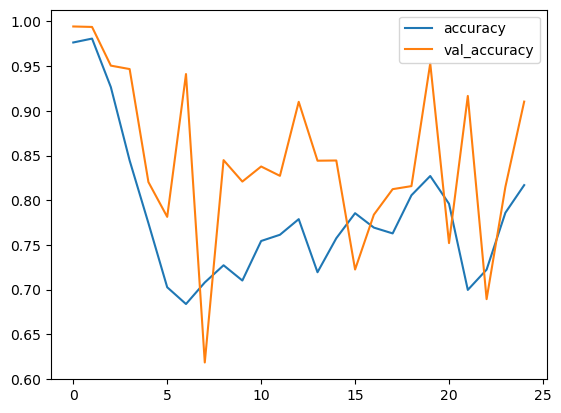

In [15]:
history_plots(r,'accuracy')

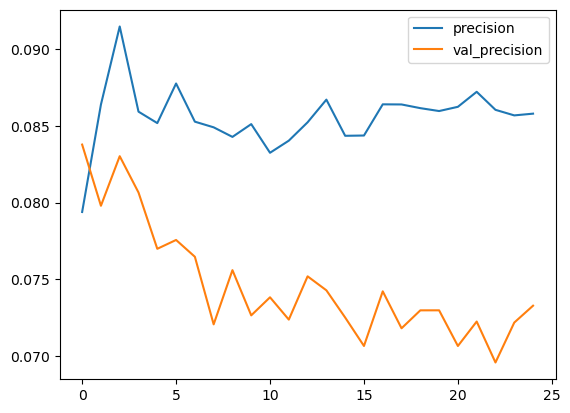

In [16]:
history_plots(r,'precision')

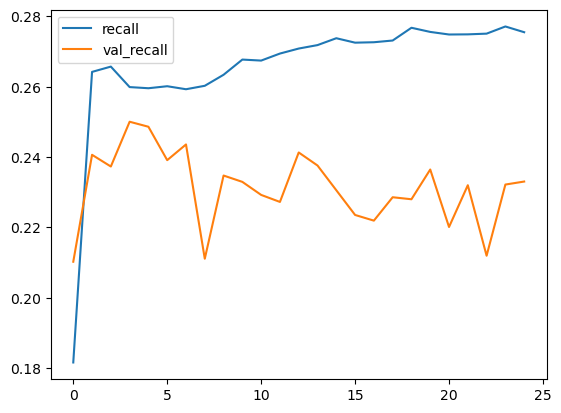

In [20]:
history_plots(r,'recall')

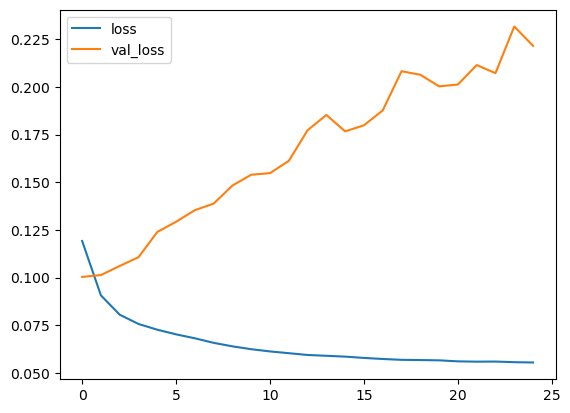

In [21]:
history_plots(r,'loss')

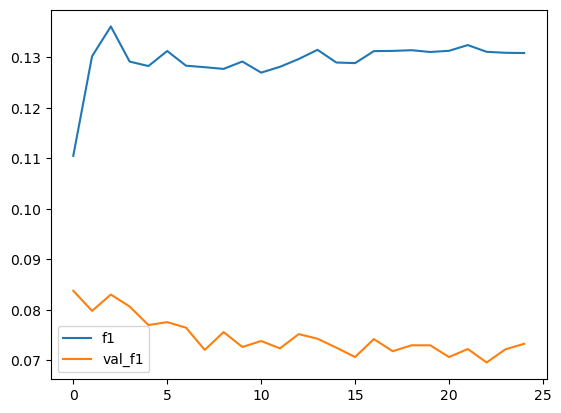

In [22]:
f1_derive(r,'precision','recall')

In [23]:
filename= "CNN_OG_02_q"
tb = TensorBoard(log_dir= "logs\\{}".format(filename))

In [24]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model2= Model(i,x)

In [25]:
model2.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

q = model2.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid), callbacks=[tb])

Epoch 1/25
1117/1117 [==============================] - 47s 42ms/step - loss: 0.0830 - accuracy: 0.9450 - precision: 0.1082 - recall: 0.3345 - val_loss: 0.0523 - val_accuracy: 0.9943 - val_precision: 0.1002 - val_recall: 0.4347
Epoch 2/25
1117/1117 [==============================] - 46s 41ms/step - loss: 0.0422 - accuracy: 0.9753 - precision: 0.1166 - recall: 0.4340 - val_loss: 0.0520 - val_accuracy: 0.9209 - val_precision: 0.1706 - val_recall: 0.4221
Epoch 3/25
1117/1117 [==============================] - 46s 41ms/step - loss: 0.0325 - accuracy: 0.9129 - precision: 0.1439 - recall: 0.4353 - val_loss: 0.0581 - val_accuracy: 0.9939 - val_precision: 0.0968 - val_recall: 0.4348
Epoch 4/25
1117/1117 [==============================] - 46s 41ms/step - loss: 0.0262 - accuracy: 0.7582 - precision: 0.1650 - recall: 0.4374 - val_loss: 0.0664 - val_accuracy: 0.5122 - val_precision: 0.1695 - val_recall: 0.4057
Epoch 5/25
1117/1117 [==============================] - 46s 41ms/step - loss: 0.0215 - a

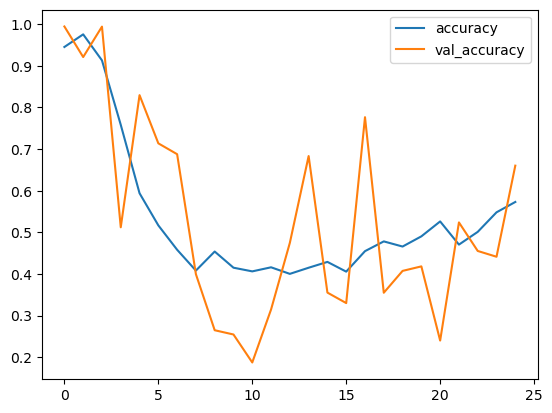

In [26]:
history_plots(q,'accuracy')

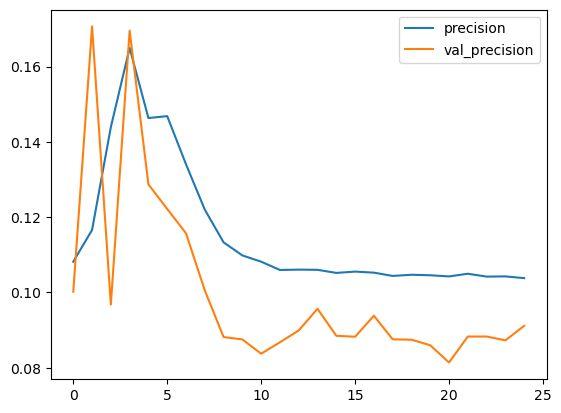

In [27]:
history_plots(q,'precision')

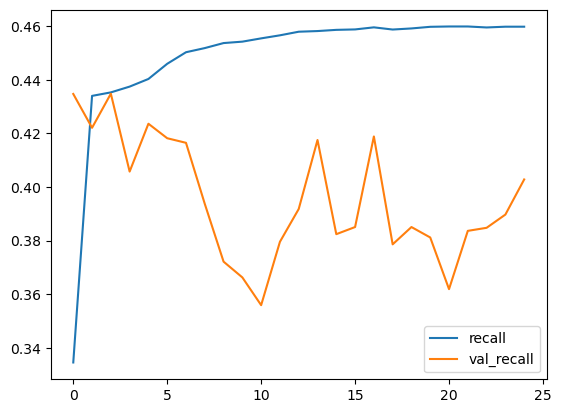

In [28]:
history_plots(q,'recall')

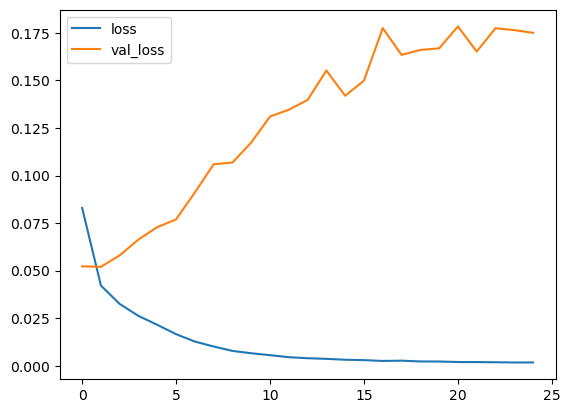

In [29]:
history_plots(q,'loss')

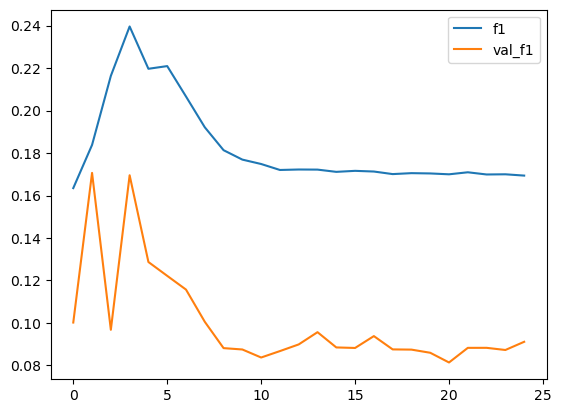

In [30]:
f1_derive(q,'precision','recall')

In [31]:
filename= "CNN_OG_03_s"
tb = TensorBoard(log_dir= "logs\\{}".format(filename))

In [32]:
D=60
m=64
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model3= Model(i,x)

In [33]:
model3.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

s = model3.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid), callbacks=[tb])

Epoch 1/25
1117/1117 [==============================] - 142s 126ms/step - loss: 0.1154 - accuracy: 0.9671 - precision: 0.0811 - recall: 0.1968 - val_loss: 0.1005 - val_accuracy: 0.9943 - val_precision: 0.0737 - val_recall: 0.2347
Epoch 2/25
1117/1117 [==============================] - 140s 126ms/step - loss: 0.0901 - accuracy: 0.9773 - precision: 0.0845 - recall: 0.2605 - val_loss: 0.1055 - val_accuracy: 0.9943 - val_precision: 0.0753 - val_recall: 0.2406
Epoch 3/25
1117/1117 [==============================] - 140s 126ms/step - loss: 0.0806 - accuracy: 0.9464 - precision: 0.0856 - recall: 0.2643 - val_loss: 0.1093 - val_accuracy: 0.9943 - val_precision: 0.0757 - val_recall: 0.2461
Epoch 4/25
1117/1117 [==============================] - 140s 126ms/step - loss: 0.0759 - accuracy: 0.9042 - precision: 0.0810 - recall: 0.2607 - val_loss: 0.1200 - val_accuracy: 0.8451 - val_precision: 0.0768 - val_recall: 0.2455
Epoch 5/25
1117/1117 [==============================] - 140s 126ms/step - loss: 

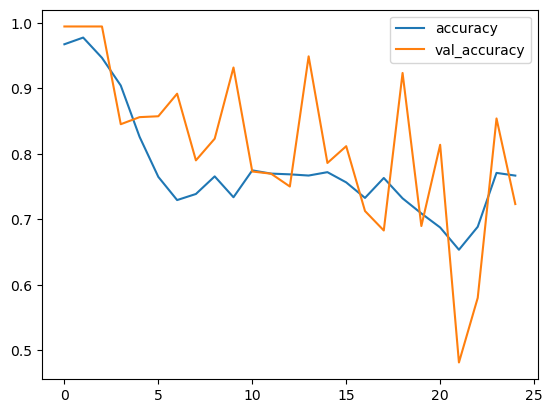

In [34]:
history_plots(s,'accuracy')

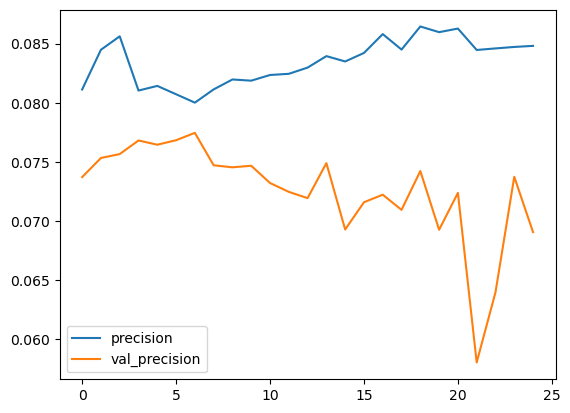

In [35]:
history_plots(s,'precision')

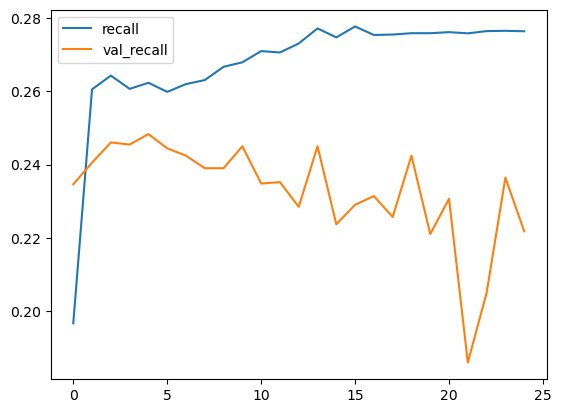

In [36]:
history_plots(s,'recall')

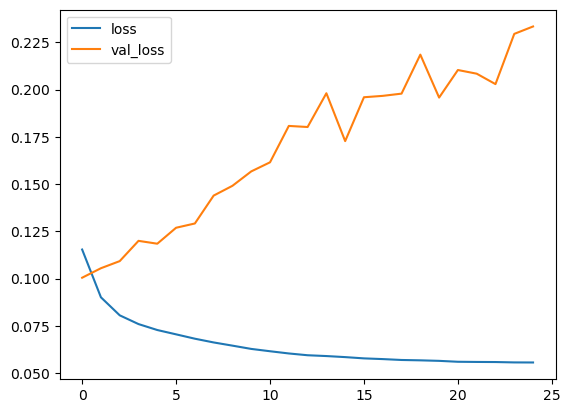

In [37]:
history_plots(s,'loss')

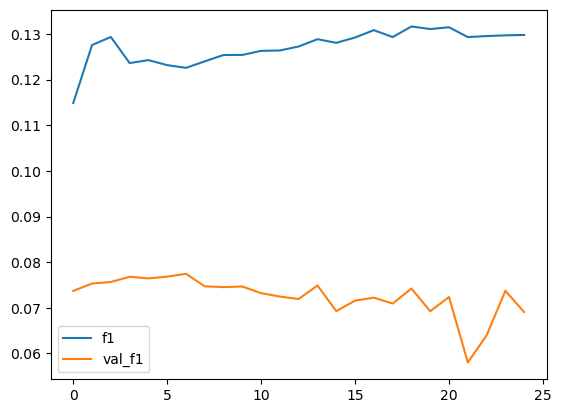

In [38]:
f1_derive(s,'precision','recall')

In [39]:
filename= "CNN_0G_00_f"
tb = TensorBoard(log_dir= "logs\\{}".format(filename))

In [40]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='sigmoid')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model= Model(i,x)

In [41]:
model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

f = model.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid), callbacks=[tb])

Epoch 1/25
1117/1117 [==============================] - 70s 62ms/step - loss: 0.1386 - accuracy: 0.9852 - precision: 0.0899 - recall: 0.0539 - val_loss: 0.1237 - val_accuracy: 0.9943 - val_precision: 0.0278 - val_recall: 0.0685
Epoch 2/25
1117/1117 [==============================] - 68s 61ms/step - loss: 0.1182 - accuracy: 0.9941 - precision: 0.0495 - recall: 0.1150 - val_loss: 0.1093 - val_accuracy: 0.9943 - val_precision: 0.0657 - val_recall: 0.2020
Epoch 3/25
1117/1117 [==============================] - 67s 60ms/step - loss: 0.0959 - accuracy: 0.9941 - precision: 0.0830 - recall: 0.2467 - val_loss: 0.1052 - val_accuracy: 0.9943 - val_precision: 0.0965 - val_recall: 0.2271
Epoch 4/25
1117/1117 [==============================] - 68s 61ms/step - loss: 0.0882 - accuracy: 0.9940 - precision: 0.0905 - recall: 0.2755 - val_loss: 0.1057 - val_accuracy: 0.9943 - val_precision: 0.2497 - val_recall: 0.1878
Epoch 5/25
1117/1117 [==============================] - 68s 61ms/step - loss: 0.0841 - a

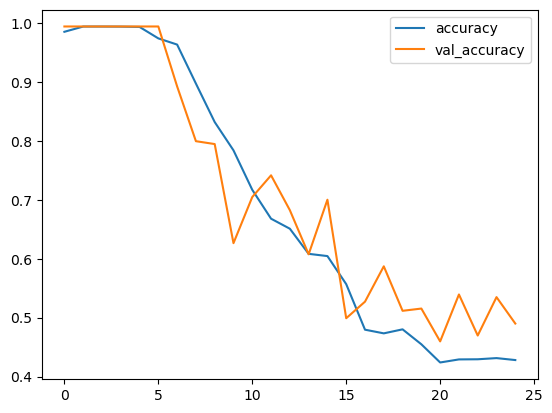

In [42]:
history_plots(f,'accuracy')

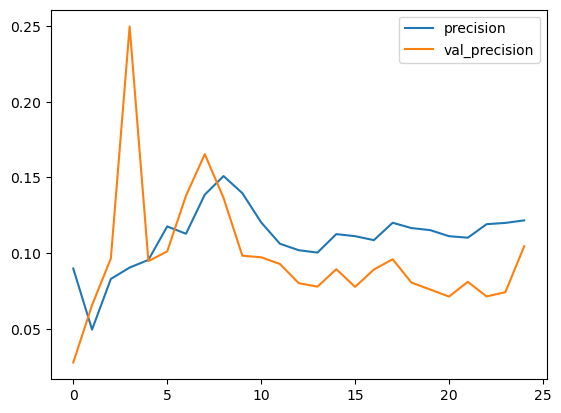

In [43]:
history_plots(f,'precision')

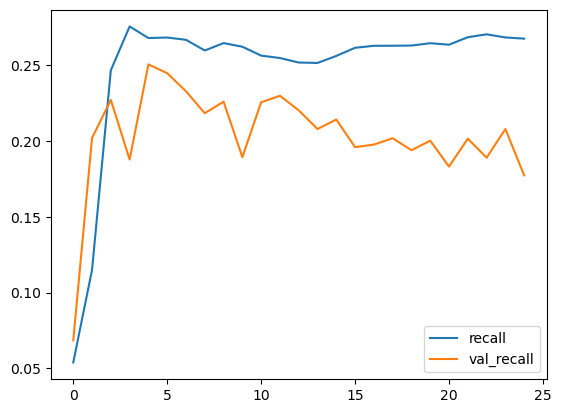

In [44]:
history_plots(f,'recall')

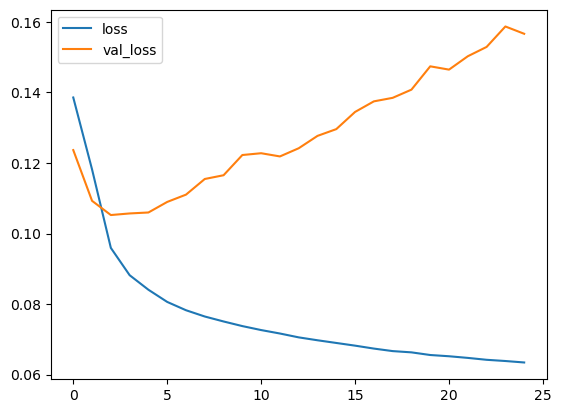

In [45]:
history_plots(f,'loss')

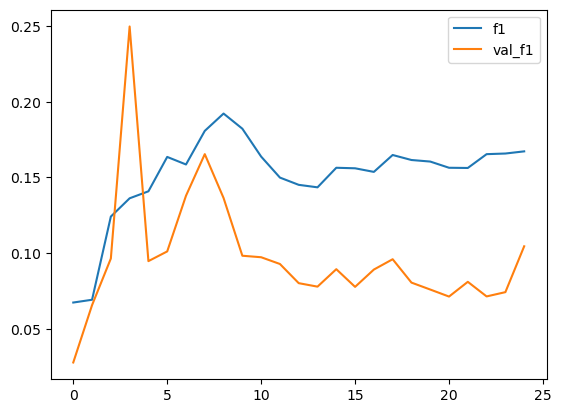

In [46]:
f1_derive(f,'precision','recall')

In [47]:
model.save('.\\models\\CNN_OG_00_f')

INFO:tensorflow:Assets written to: .\models\CNN_OG_00_f\assets


INFO:tensorflow:Assets written to: .\models\CNN_OG_00_f\assets
